<a href="https://colab.research.google.com/github/ashma01/ashma01/blob/master/GAN_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import torch.nn.functional as F

In [ ]:
#Load Fashion MNIST data set

mnist = FashionMNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

to_pil_image = torchvision.transforms.ToPILImage()

In [ ]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


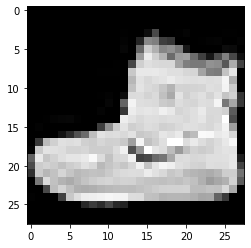

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [ ]:
from torch.utils.data import DataLoader

#Data loader
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)



first batch
torch.Size([100, 1, 28, 28])
tensor([7, 8, 9, 2, 3, 9, 5, 8, 2, 4, 9, 9, 8, 5, 2, 9, 2, 7, 9, 9, 8, 9, 6, 6,
        7, 5, 0, 7, 1, 9, 1, 7, 0, 7, 1, 5, 7, 0, 3, 3, 0, 5, 9, 9, 2, 4, 5, 4,
        4, 9, 6, 7, 9, 9, 0, 8, 0, 9, 9, 4, 4, 0, 9, 8, 2, 4, 9, 7, 5, 0, 3, 7,
        9, 0, 2, 5, 1, 6, 6, 9, 3, 7, 5, 2, 2, 6, 1, 5, 8, 0, 4, 6, 4, 0, 1, 1,
        8, 1, 0, 0])


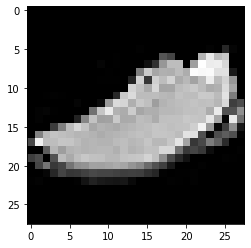

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

In [ ]:
#Discriminator networ parameter
image_size = 784
hidden_size = 256

In [ ]:
import torch.nn as nn

# #Discriminator
class Discriminator(nn.Module):
  def __init__(self, image_size, hidden_size):
    super(Discriminator, self).__init__()

    self.fc1 = nn.Linear(image_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, 1)
    self.sig = nn.Sigmoid()

  def forward(self, x):
     x = F.leaky_relu(self.fc1(x), 0.2)  
     x = F.leaky_relu(self.fc2(x), 0.2)  
     out = self.sig(self.fc3(x))
     return out


# Discriminator = nn.Sequential(
#     nn.Linear(image_size, hidden_size),
#     nn.LeakyReLU(0.2),
#     nn.Linear(hidden_size, hidden_size),
#     nn.LeakyReLU(0.2),
#     nn.Linear(hidden_size, 1),
#     nn.Sigmoid())


Discriminator_model = Discriminator(image_size, hidden_size)



In [ ]:
#Generator network parameter
latent_size = 64

# Generator = nn.Sequential(
#     nn.Linear(latent_size, hidden_size),
#     nn.ReLU(),
#     nn.Linear(hidden_size, hidden_size),
#     nn.ReLU(),
#     nn.Linear(hidden_size, image_size),
#     nn.Tanh())


# Generator.to(device);

class Generator(nn.Module):
  def __init__(self, latent_size, hidden_size, image_size):
    super(Generator, self).__init__()
    
    self.fc1 = nn.Linear(latent_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, image_size)
    self.tanh = nn.Tanh()
    
  def forward(self, x):
    # 4
    x = F.relu(self.fc1(x), 0.2) # (input, negative_slope=0.2) 
    x = F.relu(self.fc2(x), 0.2)
    out = self.tanh(self.fc3(x))
    return out

Generator_model = Generator(latent_size, hidden_size,image_size).to(device);   

In [ ]:
print(Generator_model)
print(Discriminator_model)

Generator(
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=784, bias=True)
  (tanh): Tanh()
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
y = Generator_model(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())


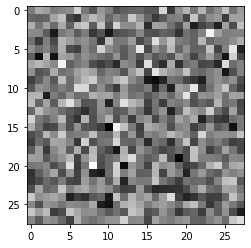

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

In [ ]:
#For discriminator training using binary cross entropy loss
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(Discriminator_model.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(Generator_model.parameters(), lr=0.0002)

In [ ]:
# utility function

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [ ]:
#Train discriminator
def train_discriminator(images):
    
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # calculate loss on real image
    outputs = Discriminator_model(images)
    d_real_image_loss = criterion(outputs, real_labels)
    real_score = outputs

    # generate fake images and calculate loss on fake image
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = Generator_model(z)
    outputs = Discriminator_model(fake_images)
    d_fake_image_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    #loss addition
    d_total_loss = d_real_image_loss + d_fake_image_loss
    # set zero grad
    reset_grad()
    # backword
    d_total_loss.backward()
    # forword
    d_optimizer.step()
    
    return d_total_loss, real_score, fake_score


In [ ]:
#Generator training

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = Generator_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    # Passing fake images and calculating loss on real label
    g_loss = criterion(Discriminator_model(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [ ]:
import os
# Saving data to visiualization

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

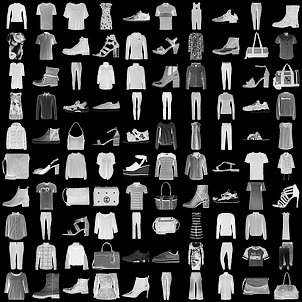

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Saving real images first
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


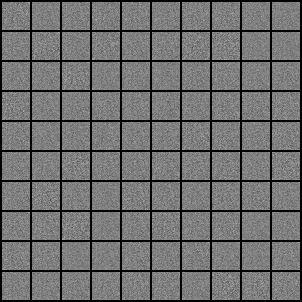

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)
# saving fake images too
def save_fake_images(index):
    fake_images = Generator_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
%%time

#Training the model now and saving fake images in the folder
num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/600], d_loss: 0.0640, g_loss: 4.1680, D(x): 0.98, D(G(z)): 0.04
Epoch [0/50], Step [400/600], d_loss: 0.2210, g_loss: 4.4072, D(x): 0.95, D(G(z)): 0.10
Epoch [0/50], Step [600/600], d_loss: 0.0489, g_loss: 5.0928, D(x): 0.98, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.1044, g_loss: 3.8336, D(x): 0.97, D(G(z)): 0.07
Epoch [1/50], Step [400/600], d_loss: 0.0397, g_loss: 3.8679, D(x): 0.99, D(G(z)): 0.03
Epoch [1/50], Step [600/600], d_loss: 0.0304, g_loss: 4.3869, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 0.0154, g_loss: 5.0514, D(x): 1.00, D(G(z)): 0.01
Epoch [2/50], Step [400/600], d_loss: 0.0290, g_loss: 6.3961, D(x): 0.99, D(G(z)): 0.01
Epoch [2/50], Step [600/600], d_loss: 0.0382, g_loss: 6.3870, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 0.0710, g_loss: 5.3176, D(x): 0.96, D(G(z)): 0.01
Epoch [3/50], Step [400/600], d_loss

In [ ]:
# Save the model checkpoints 
torch.save(Generator_model.state_dict(), 'G.ckpt')
torch.save(Discriminator_model.state_dict(), 'D.ckpt')

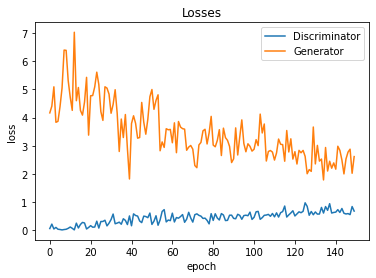

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

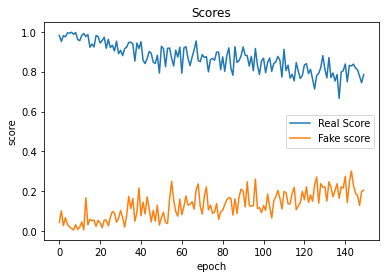

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "/content/samples/fake_images-*.png"
fp_out = "/content/samples/fake_image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)